In [2]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter

import math

In [9]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [3]:
fig_width=6
fig_height=1.5

In [4]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [5]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [6]:
def dataset_name(d):
    return {
        'books': "amazon", 
        'fb': "facebook", 
        'gap_10': "gapped 10%", 
        'normal': "normal", 
        'osm': "open street map", 
        'seq': "sequential", 
        'uniform': "uniform", 
        'wiki': "wikipedia"
    }[d]
    
def get_dataset_order(d):
    return {ds: i for i, ds in enumerate([
        'seq',
        'gap_10',
        'normal',
        'uniform',
        'books',
        'wiki',
        'fb',
        'osm',
    ])}[d]

def human_func_name(f):
    return {
        'fibonacci': "Fibonacci",
        'murmur3': "Murmur3",
        'radixspline': "RS ($\epsilon = 4, r = 18$)",
        'triespline': "PLEX ($\epsilon = 4$)"
    }[f]

def human_kicking_name(k):
    return {
            'balanced_kicking': "Balanced",
            'biased_kicking_0': "Unbiased",
            'biased_kicking_20': "Biased ($20\%$)",
            'biased_kicking_80': "Biased ($80\%$)"
           }[k]

def get_marker(f):
    return {
        'fibonacci': "*",
        'murmur3': "+",
        'radixspline': "v",
        'triespline': "^"
    }[f]

def map_probe_dist(d):
    return {'0': "uniform", '1': "exponential"}[d]

In [7]:
label = "label"
func_name = "fn_name"
dataset = "dataset"
dataset_size = "dataset_size"
dataset_order = "dataset_order"
overallocation = "overallocation"

failed = "failed"
failed_at = "failed_at"
kicking_strategy = "kicking_strategy"
max_kick_count = "max_kick_count"
total_kick_count = "total_kick_count"
primary_key_ratio = "primary_key_ratio"
table_capacity = "table_capacity"

hashtable_bytes = "hashtable_bytes"
hashtable_bytes_per_key = "hashtable_bytes_per_key"
total_bytes = "total_bytes"
hashtable_lookup = "cpu_time"
build_time = "build_time"
build_throughput = "build_throughput"
build_ns_per_key = "build_ns_per_key"
probing_distribution = "probing_distribution"

def extract_fun_name(x):
    
    raw = x[x.find("hashing::"):x.find(">")].removeprefix("hashing::").lower()
    if raw.startswith("triespline"):
        return "triespline"
    if raw.startswith("radixspline"):
        return "radixspline"
    if raw.startswith("murmur"):
        return "murmur3"
    if raw.startswith("fibonacci"):
        return "fibonacci"

cuckoo_df = df[df["name"].str.startswith("BM_hashtable") & df["name"].str.contains("Cuckoo") & (df[failed] < 1.0)].copy(deep=True)
cuckoo_df[func_name] = cuckoo_df["name"].apply(extract_fun_name)
cuckoo_df[dataset] = cuckoo_df["label"].apply(lambda x : x.split(":")[1])
cuckoo_df[dataset_order] = cuckoo_df[dataset].apply(get_dataset_order)

cuckoo_df[kicking_strategy] = cuckoo_df["label"].apply(lambda x: x.split(":")[0].removeprefix("cuckoo_4_"))

cuckoo_df[probing_distribution] = cuckoo_df["name"].apply(lambda x: map_probe_dist(x.split('/')[-2]))
cuckoo_df[hashtable_bytes_per_key] = cuckoo_df.apply(lambda x: x[hashtable_bytes] / x[dataset_size], axis=1)
cuckoo_df[build_throughput] = cuckoo_df.apply(lambda x: x[dataset_size] / x[build_time], axis=1)
cuckoo_df[build_ns_per_key] = cuckoo_df.apply(lambda x: 10**9 * x[build_time] / x[dataset_size], axis=1)
# cuckoo_df[(cuckoo_df[kicking_strategy].str.startswith("biased")) & (cuckoo_df[func_name] == "triespline")][[func_name, dataset, dataset_size, overallocation, kicking_strategy, probing_distribution, hashtable_bytes_per_key, failed, failed_at, hashtable_lookup, build_time, build_throughput, build_ns_per_key]]
cuckoo_df[[func_name, dataset, dataset_size, overallocation, kicking_strategy, probing_distribution, hashtable_bytes_per_key, failed, failed_at, hashtable_lookup, build_time, build_throughput, build_ns_per_key]]

,fn_name,dataset,dataset_size,overallocation,kicking_strategy,probing_distribution,hashtable_bytes_per_key,failed,failed_at,cpu_time,build_time,build_throughput,build_ns_per_key
512,triespline,seq,200000000.0,1.10,balanced_kicking,uniform,22.000053,0.0,200000000.0,211.579929,28.902045,6.919926e+06,144.510226
513,triespline,gap_10,200000000.0,1.10,balanced_kicking,uniform,22.000053,0.0,200000000.0,351.148138,31.152738,6.419981e+06,155.763689
514,triespline,uniform,199999975.0,1.10,balanced_kicking,uniform,22.000053,0.0,199999975.0,407.302002,38.051765,5.255997e+06,190.258847
515,triespline,normal,199459933.0,1.10,balanced_kicking,uniform,22.000053,0.0,199459933.0,401.338704,39.936681,4.994404e+06,200.224075
516,triespline,books,200000000.0,1.10,balanced_kicking,uniform,22.000053,0.0,200000000.0,416.059645,44.021055,4.543280e+06,220.105277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,radixspline,wiki,90437011.0,1.25,biased_kicking_80,exponential,25.000116,0.0,90437011.0,274.032838,11.182569,8.087320e+06,123.650363
1232,radixspline,seq,200000000.0,1.10,biased_kicking_0,uniform,22.000052,0.0,200000000.0,224.832560,19.995930,1.000204e+07,99.979650
1240,radixspline,seq,200000000.0,1.25,biased_kicking_0,uniform,25.000052,0.0,200000000.0,228.937998,20.809047,9.611204e+06,104.045234
1256,radixspline,seq,200000000.0,1.10,biased_kicking_0,exponential,22.000052,0.0,200000000.0,224.025352,20.004384,9.997809e+06,100.021918


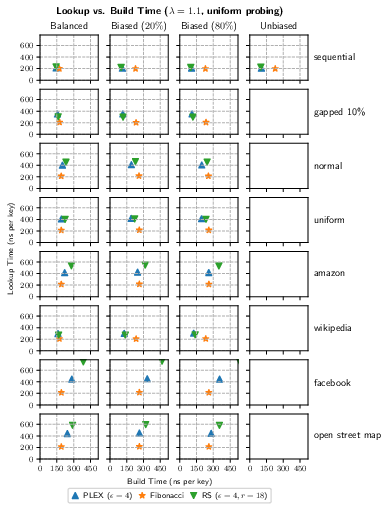

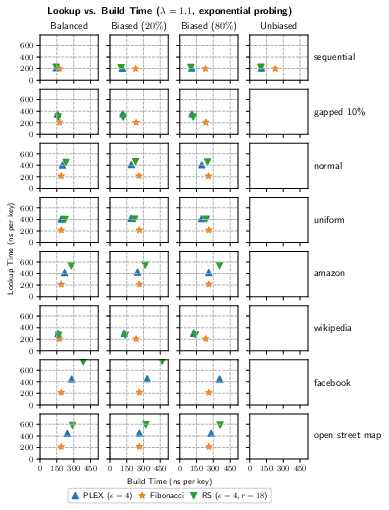

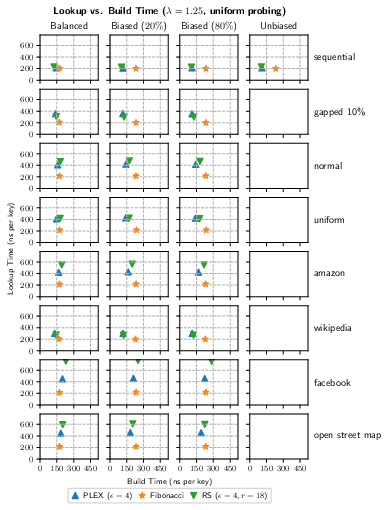

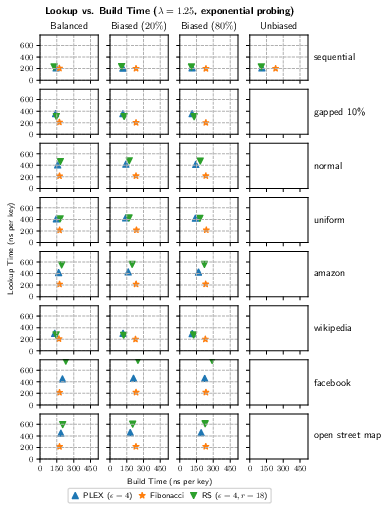

In [14]:
def plot_pareto(data, overalloc, probing_dist):
    rows = 8
    cols = 4
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.65), sharex=True, sharey=True)
    
    data = data[(data[overallocation] == overalloc) & (data[probing_distribution] == probing_dist)].copy(deep=True).sort_values(by=[dataset_order, dataset_size])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset_name(ds), 
            xy=(0, 0.5),
            xytext=(60 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        
        for j, (kicking_strat, df) in enumerate(df.groupby([kicking_strategy], sort=False)):
            ax = axs[i][j]                        
            if i == 0:
                ax.set_title(human_kicking_name(kicking_strat))

            ax.grid(linestyle='--', axis='both')
            ax.set_xlim([0, 520])
            ax.set_xticks([0, 150, 300, 450])
            ax.set_ylim([0, 780])
            ax.set_yticks([0, 200, 400, 600])
                
            for k, (name, df) in enumerate(df.groupby([func_name], sort=False)):
                ax.scatter(x=df[build_ns_per_key], y=df[hashtable_lookup], label=human_func_name(name), color=get_color(name), marker=get_marker(name))
                
    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(
        h, l,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.04),
        ncol=4,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )

    fig.suptitle(f"Lookup vs. Build Time ($\lambda = {overalloc}$, {probing_dist} probing)", y=0.93, fontweight="bold")
    fig.text(0.03, 0.5, 'Lookup Time (ns per key)', va='center', rotation='vertical')
    fig.text(0.5, 0.08, 'Build Time (ns per key)', ha='center')
        
    fig.savefig(f"cuckoo_pareto_{probing_dist}_{overalloc}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"cuckoo_pareto_{probing_dist}_{overalloc}.pgf", bbox_inches="tight", dpi=300)

for overalloc in [1.10, 1.25]:
    for probing_dist in ["uniform", "exponential"]:
        plot_pareto(cuckoo_df, overalloc=overalloc, probing_dist=probing_dist)

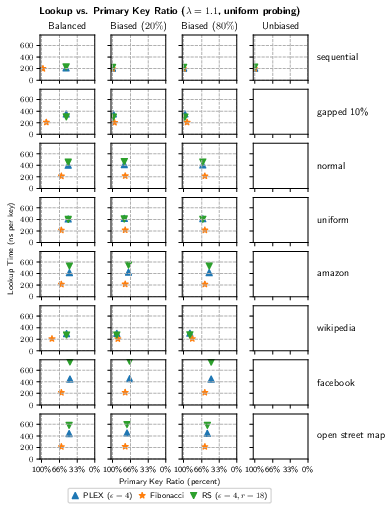

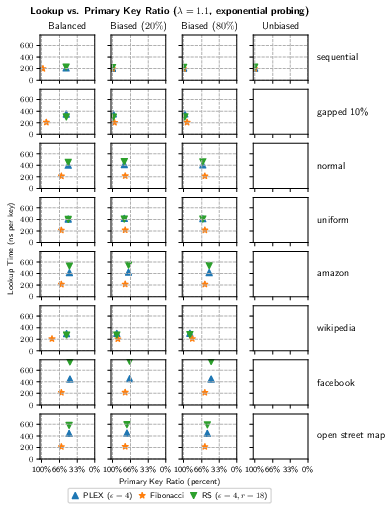

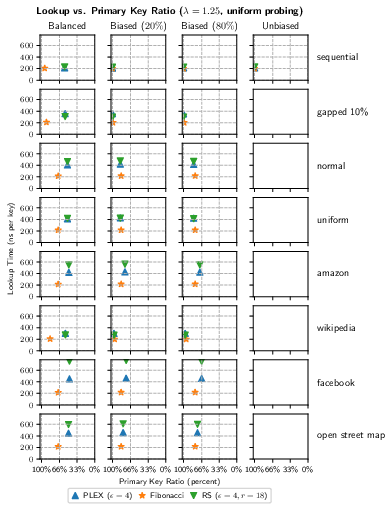

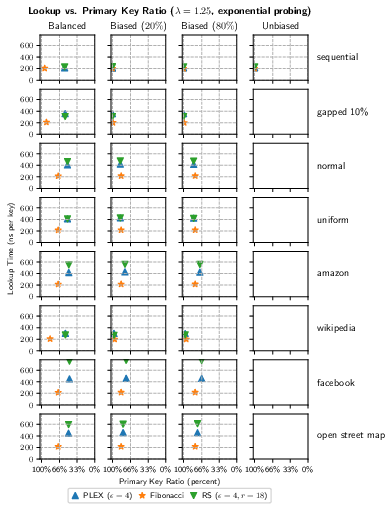

In [15]:
def plot_primary_key_ratio(data, overalloc, probing_dist):
    rows = 8
    cols = 4
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.65), sharex=True, sharey=True)
    
    data = data[(data[overallocation] == overalloc) & (data[probing_distribution] == probing_dist)].copy(deep=True).sort_values(by=[dataset_order, dataset_size])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset_name(ds), 
            xy=(0, 0.5),
            xytext=(60 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        
        for j, (kicking_strat, df) in enumerate(df.groupby([kicking_strategy], sort=False)):
            ax = axs[i][j]                        
            if i == 0:
                ax.set_title(human_kicking_name(kicking_strat))
    
            for k, (name, df) in enumerate(df.groupby([func_name], sort=False)):
                ax.scatter(x=df[primary_key_ratio], y=df[hashtable_lookup], label=human_func_name(name), color=get_color(name), marker=get_marker(name))
        
            ax.grid(linestyle='--', axis='both')
            ax.set_xticks([1.0, 0.66, 0.33, 0])
            ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
            ax.invert_xaxis()
            # for tick in ax.get_xticks():
            #     tick.set_rotation(90)
            ax.set_ylim([0, 780])
            ax.set_yticks([0, 200, 400, 600])
                
    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(
        h, l,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.04),
        ncol=4,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )

    fig.suptitle(f"Lookup vs. Primary Key Ratio ($\lambda = {overalloc}$, {probing_dist} probing)", y=0.93, fontweight="bold")
    fig.text(0.03, 0.5, 'Lookup Time (ns per key)', va='center', rotation='vertical')
    fig.text(0.5, 0.08, 'Primary Key Ratio (percent)', ha='center')
    fig.subplots_adjust(wspace=0.3)
        
    fig.savefig(f"cuckoo_primary_key_ratio_{probing_dist}_{overalloc}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"cuckoo_primary_key_ratio_{probing_dist}_{overalloc}.pgf", bbox_inches="tight", dpi=300)

for overalloc in [1.10, 1.25]:
    for probing_dist in ["uniform", "exponential"]:
        plot_primary_key_ratio(cuckoo_df, overalloc=overalloc, probing_dist=probing_dist)